# Let's Get Familiar with PSG Data

In [2]:
%load_ext autoreload
%autoreload 2

import os
os.chdir('..')

from pathlib import Path
import matplotlib.pyplot as plt
import pprint

import numpy as np

from openpsg.utils.vis_tools.datasets import coco_dir
from openpsg.utils.vis_tools.preprocess import load_json

from detectron2.data.detection_utils import read_image
from detectron2.utils.colormap import colormap
from panopticapi.utils import rgb2id

def get_colormap(num_colors: int):
    return (np.resize(colormap(), (num_colors, 3))).tolist()

## Loading PSG Data

This script help users to get familiar with PSG data.
All PSG annotations are stored in `psg.json`.
We also provide `tiny_psg.json`, which contains 1/4 size of original training and 1000 val samples to accelerate debugging process.
We first load `psg.json`.

In [3]:
# set working path as home dir to easy access data
psg_dataset_file = load_json(Path("data/psg/psg_test.json"))
print('keys: ', list(psg_dataset_file.keys()))

keys:  ['data', 'thing_classes', 'stuff_classes', 'predicate_classes', 'test_image_ids']


You can see that psg_dataset_file contains the label system represented by 'thing_classes', 'stuff_classes', 'predicate_classes'.
'test_image_ids' shows the index for test (in fact validation set). Some details are as below.

In [4]:
psg_thing_cats = psg_dataset_file['thing_classes']
psg_stuff_cats = psg_dataset_file['stuff_classes']
psg_obj_cats = psg_thing_cats + psg_stuff_cats
psg_rel_cats = psg_dataset_file['predicate_classes']
psg_dataset = {d["image_id"]: d for d in psg_dataset_file['data']}
# psg_dataset_coco_id = {d["coco_image_id"]: d for d in psg_dataset_file['data']}

print('Number of images: {}'.format(len(psg_dataset)))
print('# Object Classes: {}'.format(len(psg_obj_cats)))
print('# Relation Classes: {}'.format(len(psg_rel_cats)))

Number of images: 1000
# Object Classes: 133
# Relation Classes: 56


## Visualize PSG data

In [18]:
example_img_id = '000000019742'
data = psg_dataset[example_img_id]
print('keys: ', list(psg_dataset[example_img_id].keys()))

keys:  ['file_name', 'height', 'width', 'image_id', 'pan_seg_file_name', 'segments_info', 'relations', 'annotations', 'coco_image_id']


In [19]:
# first check values other than ['pan_seg_file_name', 'segments_info', 'relations', 'annotations']
data_simple = {}
for k in data:
    if k not in ['segments_info', 'relations', 'annotations']:
        data_simple[k] = data[k]
pprint.pprint(data_simple)

{'coco_image_id': '19742',
 'file_name': 'val2017/000000019742.jpg',
 'height': 500,
 'image_id': '000000019742',
 'pan_seg_file_name': 'panoptic_val2017/000000019742.png',
 'width': 374}


In [20]:
pprint.pprint(data['segments_info'])

[{'area': 34436, 'category_id': 75, 'id': 1257078, 'iscrowd': 0, 'isthing': 1},
 {'area': 145804,
  'category_id': 112,
  'id': 5729932,
  'iscrowd': 0,
  'isthing': 0}]


In [21]:
pprint.pprint(data['annotations'])

[{'bbox': [172, 72, 167, 275], 'bbox_mode': 1, 'category_id': 75},
 {'bbox': [0, 0, 500, 374], 'bbox_mode': 1, 'category_id': 112}]


In [9]:
pprint.pprint(data['relations'])

[[0, 8, 14],
 [1, 8, 14],
 [4, 9, 3],
 [6, 7, 0],
 [6, 5, 0],
 [6, 8, 0],
 [3, 8, 3],
 [6, 3, 0],
 [6, 0, 0],
 [6, 1, 0],
 [6, 2, 0],
 [6, 4, 0]]


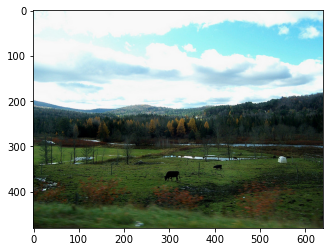

In [10]:
# show origin image
img = read_image(coco_dir / data["file_name"], format="RGB")
plt.imshow(img)
plt.show()

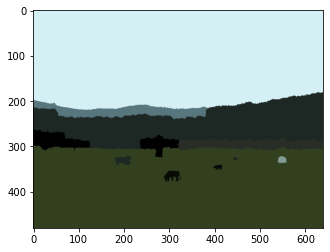

Segments IDs:  [       0   461576   526341  2113586  2303773  2499614  2567465  8287832
  9739395 16052437]
Segments Annotations: 
[{'area': 506, 'category_id': 19, 'id': 461576, 'iscrowd': 0, 'isthing': 1},
 {'area': 127, 'category_id': 19, 'id': 526341, 'iscrowd': 0, 'isthing': 1},
 {'area': 36, 'category_id': 19, 'id': 2499614, 'iscrowd': 0, 'isthing': 1},
 {'area': 6356, 'category_id': 99, 'id': 2567465, 'iscrowd': 0, 'isthing': 0},
 {'area': 236, 'category_id': 107, 'id': 9739395, 'iscrowd': 0, 'isthing': 0},
 {'area': 43811, 'category_id': 116, 'id': 2303773, 'iscrowd': 0, 'isthing': 0},
 {'area': 133002,
  'category_id': 119,
  'id': 16052437,
  'iscrowd': 0,
  'isthing': 0},
 {'area': 7159, 'category_id': 124, 'id': 8287832, 'iscrowd': 0, 'isthing': 0},
 {'area': 110312,
  'category_id': 125,
  'id': 2113586,
  'iscrowd': 0,
  'isthing': 0}]


In [11]:
# show segments image
seg_map = read_image(coco_dir / data["pan_seg_file_name"], format="RGB")
plt.imshow(seg_map)
plt.show()
# show seg annotations
seg_map = rgb2id(seg_map)
print('Segments IDs: ', np.unique(seg_map))
print('Segments Annotations: ')
pprint.pprint(data["segments_info"])

In [17]:
len(data["segments_info"])

9

In [12]:
# get seperate masks
masks = []
labels_coco = []
for i, s in enumerate(data["segments_info"]):
    label = psg_obj_cats[s["category_id"]]
    labels_coco.append(label)
    masks.append(seg_map == s["id"])

In [13]:
# generate colormap for masks
colormap_coco = get_colormap(len(data["segments_info"]))
colormap_coco = (np.array(colormap_coco) / 255).tolist()

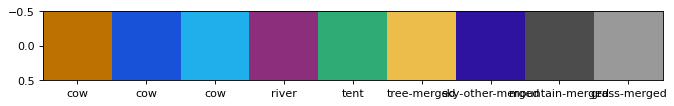

In [14]:
# show label and corresponding color
plt.figure(figsize=(10, 4), dpi=80)
plt.xticks(range(len(labels_coco)), labels_coco, fontsize=10)
plt.imshow(np.array(colormap_coco).reshape(1,-1,3))
plt.show()

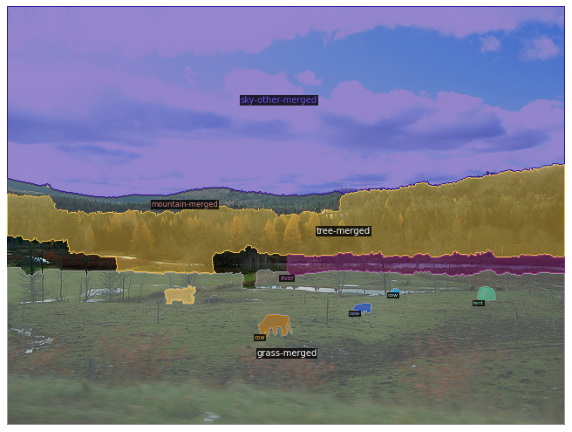

In [15]:
from openpsg.utils.vis_tools.detectron_viz import Visualizer
viz = Visualizer(img)
viz.overlay_instances(
    labels=labels_coco,
    masks=masks,
    assigned_colors=colormap_coco,
)
viz_img = viz.get_output().get_image()
plt.figure(figsize=(10,10))
plt.imshow(viz_img)
plt.axis('off')
plt.show()

In [16]:
# show triplets
for s_idx, o_idx, rel_id in data["relations"]:
    s_label = labels_coco[s_idx]
    o_label = labels_coco[o_idx]
    rel_label = psg_rel_cats[rel_id]
    print(s_label, rel_label, o_label)

cow standing on grass-merged
cow standing on grass-merged


IndexError: list index out of range